### 1. Train the Two Tower network

In [1]:
%load_ext autoreload
%autoreload 2
from utils.utils import *
from utils.utils_train import *

In [2]:
# Load SBERT Embeddings
queries, query_embeddings, product_embeddings = load_raw_queries()

# load ids_toys from disk
with open('output/ids_toys.pkl', 'rb') as file:
    ids_toys = pickle.load(file)
    print(len(ids_toys))
    ids_present = [_id for _id in ids_toys if _id in query_embeddings]

# Assemble qb & xb input embeddings
qb = torch.stack([torch.tensor(query_embeddings[_id]) for _id in ids_present])
xb = torch.tensor(np.array([product_embeddings[_id] for _id in ids_present]))

# Split Dataset into Train and Test
(qb_train, qb_test), (xb_train, xb_test), (idx_train, idx_test) = shuffle_and_split(qb, xb, seed=12)
print('qb_train.shape:', qb_train.shape)
print('qb_test.shape:', qb_test.shape)


loaded (queries, query_embeddings, product_embeddings) from  output/raw_queries.pkl
84373
qb_train.shape: torch.Size([20560, 768])
qb_test.shape: torch.Size([5140, 768])


In [3]:
# Two-Tower Pytorch Model
d = hidden_dim = qb.shape[-1]
learning_rate = 0.0001

# Initialize the network
model = TwoTowerNetwork(d, hidden_dim, learning_rate=learning_rate)

list_recall3 = []
list_test_epochs = []

recall@3  = 0.039                    
recall@3  = 0.090                    
recall@3  = 0.079                    
recall@3  = 0.041                    
recall@3  = 0.030                    
recall@3  = 0.046                    
recall@3  = 0.050                    
recall@3  = 0.065                    
recall@3  = 0.068                    
recall@3  = 0.080                    
recall@3  = 0.084                    
recall@3  = 0.095                    
recall@3  = 0.099                    
recall@3  = 0.116                    
recall@3  = 0.123                    
recall@3  = 0.142                    
recall@3  = 0.150                    
recall@3  = 0.176                    
recall@3  = 0.190                    
recall@3  = 0.205                    
recall@3  = 0.220                    
recall@3  = 0.237                    
recall@3  = 0.251                    
recall@3  = 0.270                    
recall@3  = 0.271                    


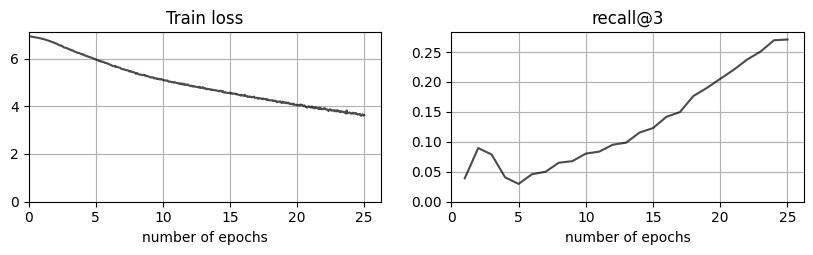

recall@3  = 0.284                    
recall@3  = 0.304                    
recall@3  = 0.326                    
recall@3  = 0.331                    
recall@3  = 0.343                    
recall@3  = 0.352                    
recall@3  = 0.363                    
recall@3  = 0.377                    
recall@3  = 0.382                    
recall@3  = 0.402                    
recall@3  = 0.392                    
recall@3  = 0.411                    
recall@3  = 0.428                    
recall@3  = 0.438                    
recall@3  = 0.441                    
recall@3  = 0.444                    
recall@3  = 0.454                    
recall@3  = 0.475                    
recall@3  = 0.468                    
recall@3  = 0.485                    
recall@3  = 0.503                    
recall@3  = 0.509                    
recall@3  = 0.518                    
recall@3  = 0.516                    
recall@3  = 0.522                    


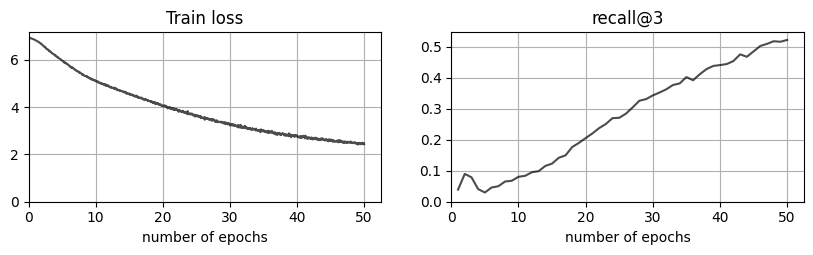

recall@3  = 0.539                    
recall@3  = 0.527                    
recall@3  = 0.559                    
recall@3  = 0.550                    
recall@3  = 0.556                    
recall@3  = 0.569                    
recall@3  = 0.577                    
recall@3  = 0.576                    
recall@3  = 0.581                    
recall@3  = 0.580                    
recall@3  = 0.593                    
recall@3  = 0.599                    
recall@3  = 0.592                    
recall@3  = 0.600                    
recall@3  = 0.610                    
recall@3  = 0.602                    
recall@3  = 0.618                    
recall@3  = 0.611                    
recall@3  = 0.624                    
recall@3  = 0.625                    
recall@3  = 0.631                    
recall@3  = 0.627                    
recall@3  = 0.636                    
recall@3  = 0.640                    
recall@3  = 0.645                    


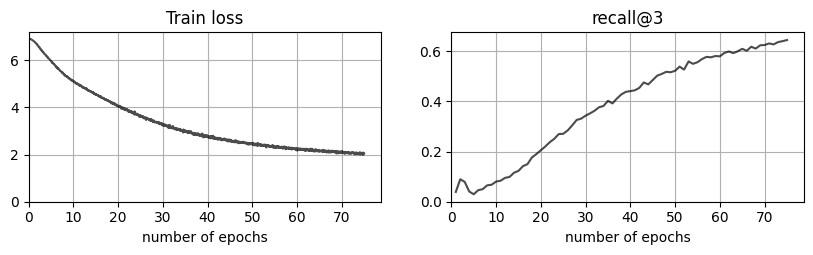

recall@3  = 0.641                    
recall@3  = 0.648                    
recall@3  = 0.664                    
recall@3  = 0.651                    
recall@3  = 0.661                    
recall@3  = 0.656                    
recall@3  = 0.651                    
recall@3  = 0.666                    
recall@3  = 0.668                    
recall@3  = 0.682                    
recall@3  = 0.677                    
recall@3  = 0.665                    
recall@3  = 0.669                    
recall@3  = 0.683                    
recall@3  = 0.678                    
recall@3  = 0.686                    
recall@3  = 0.681                    
recall@3  = 0.668                    
recall@3  = 0.676                    
recall@3  = 0.687                    
recall@3  = 0.684                    
recall@3  = 0.681                    
recall@3  = 0.690                    
recall@3  = 0.686                    
recall@3  = 0.678                    


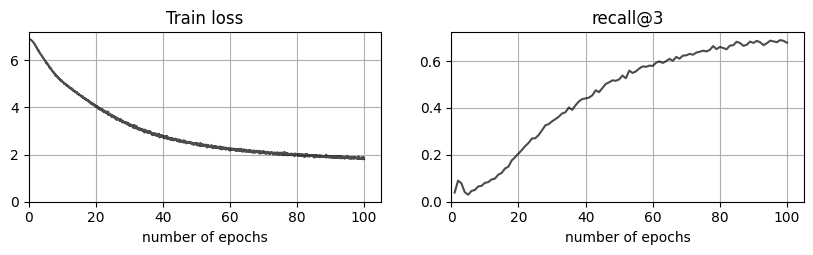

recall@3  = 0.679                    
recall@3  = 0.689                    
recall@3  = 0.681                    
recall@3  = 0.691                    
recall@3  = 0.688                    
recall@3  = 0.695                    
recall@3  = 0.697                    
recall@3  = 0.686                    
recall@3  = 0.685                    
recall@3  = 0.698                    
recall@3  = 0.711                    
recall@3  = 0.692                    
recall@3  = 0.689                    
recall@3  = 0.690                    
recall@3  = 0.683                    
recall@3  = 0.697                    
recall@3  = 0.698                    
recall@3  = 0.693                    
recall@3  = 0.696                    
recall@3  = 0.699                    
recall@3  = 0.692                    
recall@3  = 0.685                    
recall@3  = 0.713                    
recall@3  = 0.694                    
recall@3  = 0.694                    


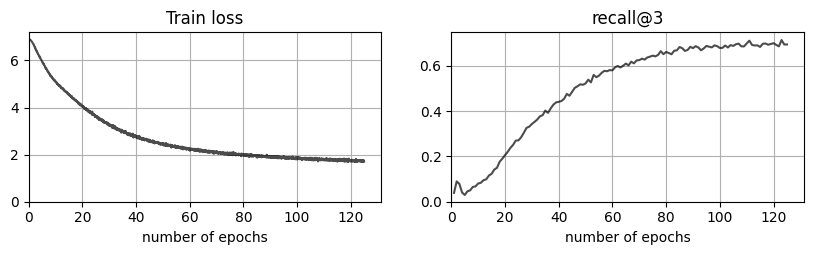

recall@3  = 0.696                    
recall@3  = 0.687                    
recall@3  = 0.698                    
recall@3  = 0.705                    
recall@3  = 0.690                    
recall@3  = 0.704                    
recall@3  = 0.699                    
recall@3  = 0.699                    
recall@3  = 0.707                    
recall@3  = 0.693                    
recall@3  = 0.698                    
recall@3  = 0.702                    
recall@3  = 0.691                    
recall@3  = 0.703                    
recall@3  = 0.705                    
recall@3  = 0.705                    
recall@3  = 0.697                    
recall@3  = 0.694                    
recall@3  = 0.692                    
recall@3  = 0.717                    
recall@3  = 0.696                    
recall@3  = 0.717                    
recall@3  = 0.706                    
recall@3  = 0.698                    
recall@3  = 0.701                    


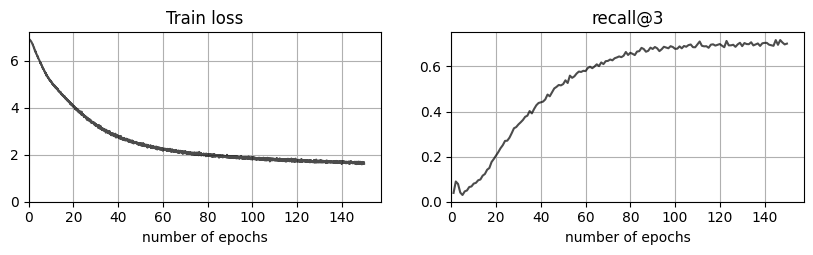

recall@3  = 0.703                    
recall@3  = 0.695                    
recall@3  = 0.697                    
recall@3  = 0.694                    
recall@3  = 0.700                    
recall@3  = 0.714                    
recall@3  = 0.703                    
recall@3  = 0.712                    
recall@3  = 0.697                    
recall@3  = 0.709                    
recall@3  = 0.704                    
recall@3  = 0.704                    
recall@3  = 0.713                    
recall@3  = 0.708                    
recall@3  = 0.717                    
recall@3  = 0.713                    
recall@3  = 0.711                    
recall@3  = 0.720                    
recall@3  = 0.708                    
recall@3  = 0.713                    
recall@3  = 0.700                    
recall@3  = 0.711                    
recall@3  = 0.707                    
recall@3  = 0.700                    
recall@3  = 0.714                    


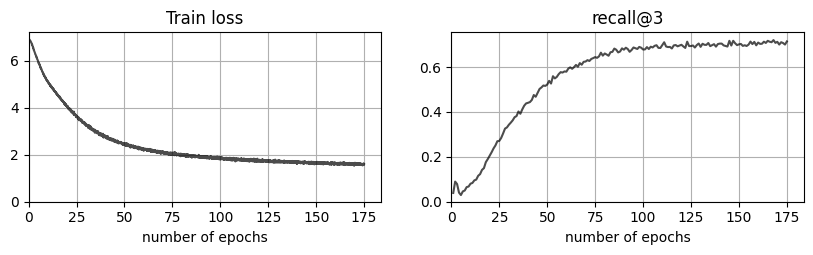

recall@3  = 0.722                    
recall@3  = 0.714                    
recall@3  = 0.709                    
recall@3  = 0.724                    
recall@3  = 0.710                    
recall@3  = 0.699                    
recall@3  = 0.717                    
recall@3  = 0.700                    
recall@3  = 0.711                    
recall@3  = 0.712                    
recall@3  = 0.712                    
recall@3  = 0.713                    
recall@3  = 0.710                    
recall@3  = 0.715                    
recall@3  = 0.720                    
recall@3  = 0.716                    
recall@3  = 0.720                    
recall@3  = 0.721                    
recall@3  = 0.714                    
recall@3  = 0.718                    
recall@3  = 0.721                    
recall@3  = 0.712                    
recall@3  = 0.717                    
recall@3  = 0.698                    
recall@3  = 0.709                    


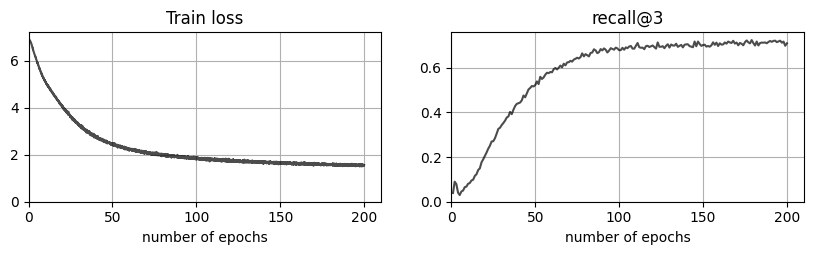

recall@3  = 0.707                    
recall@3  = 0.712                    
recall@3  = 0.719                    
recall@3  = 0.709                    
recall@3  = 0.694                    
recall@3  = 0.711                    
recall@3  = 0.701                    
recall@3  = 0.706                    
recall@3  = 0.709                    
recall@3  = 0.704                    
recall@3  = 0.709                    
recall@3  = 0.689                    
recall@3  = 0.699                    
recall@3  = 0.707                    
recall@3  = 0.691                    
recall@3  = 0.717                    
recall@3  = 0.707                    
recall@3  = 0.716                    
recall@3  = 0.685                    
recall@3  = 0.693                    
recall@3  = 0.700                    
recall@3  = 0.707                    
recall@3  = 0.689                    
recall@3  = 0.696                    
recall@3  = 0.697                    


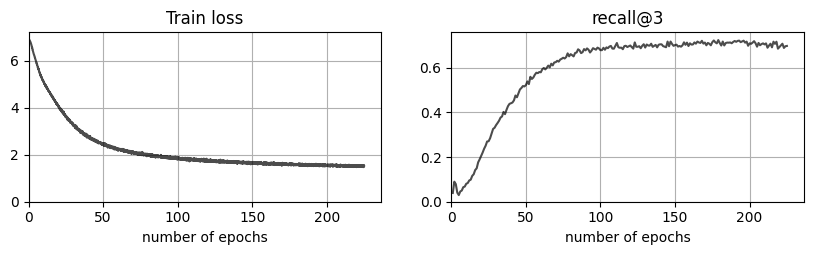

recall@3  = 0.697                    
recall@3  = 0.710                    
recall@3  = 0.713                    
recall@3  = 0.693                    
recall@3  = 0.692                    
recall@3  = 0.695                    
recall@3  = 0.690                    
recall@3  = 0.689                    
recall@3  = 0.711                    
recall@3  = 0.692                    
recall@3  = 0.709                    
recall@3  = 0.718                    
recall@3  = 0.702                    
recall@3  = 0.705                    
recall@3  = 0.694                    
recall@3  = 0.703                    
recall@3  = 0.701                    
recall@3  = 0.698                    
recall@3  = 0.706                    
recall@3  = 0.701                    
recall@3  = 0.685                    
recall@3  = 0.701                    
recall@3  = 0.702                    
recall@3  = 0.703                    
recall@3  = 0.687                    


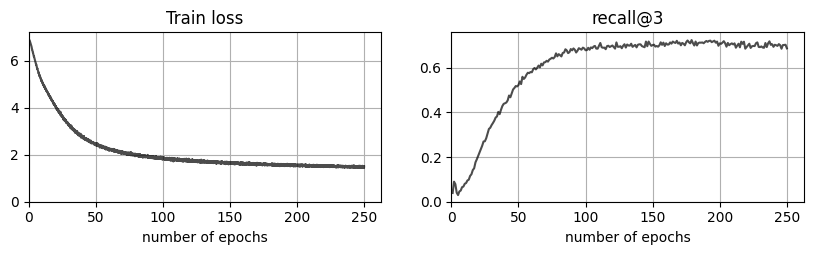

recall@3  = 0.710                    
recall@3  = 0.694                    
recall@3  = 0.701                    
recall@3  = 0.692                    
recall@3  = 0.705                    
recall@3  = 0.695                    
recall@3  = 0.700                    
recall@3  = 0.718                    
recall@3  = 0.701                    
recall@3  = 0.694                    
recall@3  = 0.714                    
recall@3  = 0.701                    
recall@3  = 0.688                    
recall@3  = 0.703                    
recall@3  = 0.718                    
recall@3  = 0.690                    
recall@3  = 0.707                    
recall@3  = 0.710                    
recall@3  = 0.694                    
recall@3  = 0.707                    
recall@3  = 0.681                    
recall@3  = 0.689                    
recall@3  = 0.704                    
recall@3  = 0.726                    
recall@3  = 0.698                    


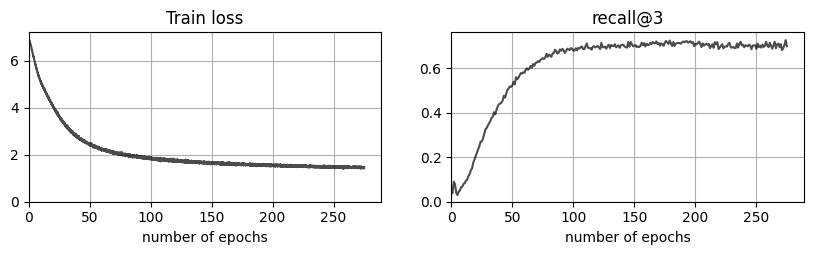

recall@3  = 0.710                    
recall@3  = 0.700                    
recall@3  = 0.697                    
recall@3  = 0.692                    
recall@3  = 0.692                    
recall@3  = 0.707                    
recall@3  = 0.688                    
recall@3  = 0.711                    
recall@3  = 0.722                    
recall@3  = 0.687                    
recall@3  = 0.707                    
recall@3  = 0.705                    
recall@3  = 0.687                    
recall@3  = 0.696                    
recall@3  = 0.700                    
recall@3  = 0.696                    
recall@3  = 0.674                    
recall@3  = 0.714                    
recall@3  = 0.683                    
recall@3  = 0.696                    
recall@3  = 0.683                    
recall@3  = 0.707                    
recall@3  = 0.699                    
recall@3  = 0.689                    
recall@3  = 0.686                    


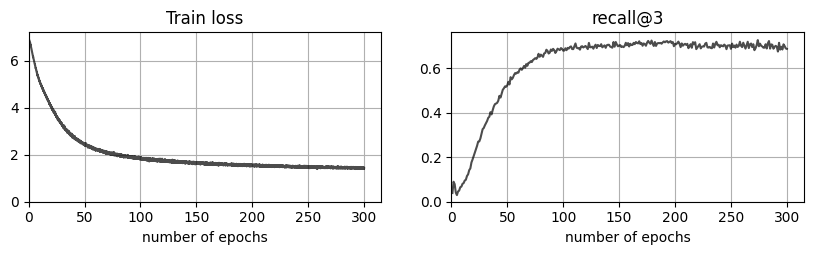

In [4]:
## TRAIN
# Hyperparameters
batch_size = 1024 
num_epochs = 1
label_smoothing = 0.1

for i in range(300):
    (qb_train, _), (xb_train, _), (_) = shuffle_and_split(qb_train, xb_train, split=1)
    
    model.train(qb_train, xb_train, num_epochs, batch_size, label_smoothing)
    write_output_embeddings(model, qb_test, xb_test) 
    os.system('cd utils && python3 utils_infer.py')
    with open('output/recall3.json', 'r') as file:
        out = json.load(file)
    recall3 = out['recall3']
    list_test_epochs.append(model.epochs[-1])
    list_recall3.append(recall3) 
    
    if (i+1) % 25 == 0:
        model.plot(qb_train, batch_size, list_test_epochs, list_recall3)
    plt.show()


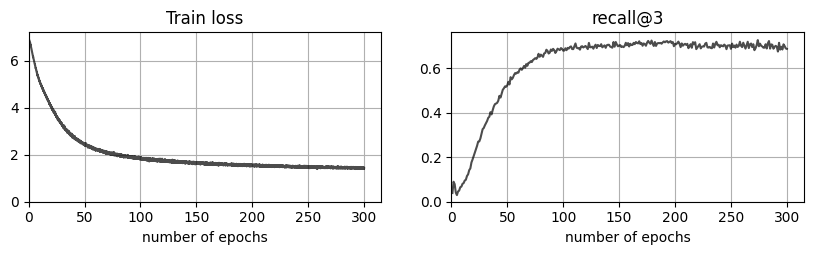

In [5]:
model.plot(qb_train, batch_size, list_test_epochs, list_recall3)


In [ ]:
# TODO:
# 1. figure out how to incorporate a learning_rate scheduler
# 2. print the top 3 results for hits. 

### The End

In [ ]:
# Load queries, ids_toys, ids_present
with open('output/raw_queries.pkl', 'rb') as file:
    queries, _, _ = pickle.load(file)

with open('output/ids_toys.pkl', 'rb') as file:
    ids_toys = pickle.load(file)
    ids_present = [_id for _id in ids_toys if _id in query_embeddings]


In [5]:
top_ids = [ids_present[idx_test[i]] for i in I[0]]
names = [info[_id]['name'] for _id in top_ids]
details = [info[_id]['details'] for _id in top_ids]
description = [info[_id]['description'] for _id in top_ids]
queries[ids_present[idx_test[0]]]

"I need to buy a Super-duper Tutu/Cape/Mask set in size 4-6 for my 4-6-year-old. It's a 3-piece set perfect for little Superheroines and Rock Stars!"